In [1]:
import pandas as pd

# Load the data
population = pd.read_csv("Population.csv")

# Clean column names: lowercase, replace hyphens with underscores
population.columns = (
    population.columns
    .str.lower()
    .str.replace("-", "_")
    .str.replace(" ", "_")
)

# Show cleaned columns
print("Cleaned columns:", population.columns.tolist())

# Confirm data types and nulls (should be fine)
print(population.info())
print(population.isnull().sum())

# Optional: Save cleaned version for PostgreSQL import
population.to_csv("p_cleaned.csv", index=False)


Cleaned columns: ['sa2_code', 'sa2_name', '0_4_people', '5_9_people', '10_14_people', '15_19_people', '20_24_people', '25_29_people', '30_34_people', '35_39_people', '40_44_people', '45_49_people', '50_54_people', '55_59_people', '60_64_people', '65_69_people', '70_74_people', '75_79_people', '80_84_people', '85_and_over_people', 'total_people']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sa2_code            373 non-null    int64 
 1   sa2_name            373 non-null    object
 2   0_4_people          373 non-null    int64 
 3   5_9_people          373 non-null    int64 
 4   10_14_people        373 non-null    int64 
 5   15_19_people        373 non-null    int64 
 6   20_24_people        373 non-null    int64 
 7   25_29_people        373 non-null    int64 
 8   30_34_people        373 non-null    int64 
 9   35_39_people  

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

In [3]:
# This loads the POIs from the REST service directly
poi_url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query?where=1%3D1&outFields=*&f=geojson"

pois = gpd.read_file(poi_url)
print(pois.columns)
pois.head()

Index(['objectid', 'topoid', 'poigroup', 'poitype', 'poiname', 'poilabel',
       'poilabeltype', 'poialtlabel', 'poisourcefeatureoid', 'accesscontrol',
       'startdate', 'enddate', 'lastupdate', 'msoid', 'centroidid',
       'shapeuuid', 'changetype', 'processstate', 'urbanity', 'geometry'],
      dtype='object')


,objectid,topoid,poigroup,poitype,poiname,poilabel,poilabeltype,poialtlabel,poisourcefeatureoid,accesscontrol,startdate,enddate,lastupdate,msoid,centroidid,shapeuuid,changetype,processstate,urbanity,geometry
0,1,500000000,9,Mine - Underground,None,Mine - Underground,GENERIC,None,157,1,1628668563000,32503680000000,1628668617000,233046,None,729e2b57-0cd4-3f70-90fa-9dce09e34a8e,I,None,S,POINT (152.12202 -31.10616)
1,2,500005504,3,Lookout,KUNDERANG LOOKOUT,KUNDERANG LOOKOUT,NAMED,None,56,1,1285588392000,32503680000000,1285588392535,83091,None,d88a28a8-c572-3992-995f-d26a274aea18,I,None,S,POINT (152.29869 -31.02148)
2,3,500005505,3,Lookout,FALLS LOOKOUT,FALLS LOOKOUT,NAMED,None,56,1,1285588392000,32503680000000,1285588392535,83691,None,21b476d2-6519-3e28-8b19-1526fcb9652f,I,None,S,POINT (152.33786 -31.01576)
3,4,500005507,3,Lookout,MCCOYS LOOKOUT,MCCOYS LOOKOUT,NAMED,None,56,1,1285588392000,32503680000000,1285588392535,83380,None,016d69b2-6530-39e7-89a6-6e3054df55ac,I,None,S,POINT (152.34181 -31.01897)
4,5,500012781,3,Picnic Area,WILSON RIVER PICNIC AREA,WILSON RIVER PICNIC AREA,NAMED,None,62,1,1608714678000,32503680000000,1608714706360,231054,None,49ad26c8-609e-3aa0-b4ad-51459b43ab51,M,None,S,POINT (152.47882 -31.20754)


In [4]:
# Load stops.txt
stops = pd.read_csv('Stops.txt')

# Preview
stops.head()

# Some cleaning
# Drop rows where stop_lat or stop_lon is missing
stops = stops.dropna(subset=['stop_lat', 'stop_lon'])

# We want to only select the stops inside three areas: 
# Inner West, North Sydney and Hornsby, City and Inner South

# No column name telling which region a stop belongs to
# So: use the stop's latitude and longitude (stop_lat, stop_lon) to filter our disired data

In [5]:
sa2 = gpd.read_file("~/Desktop/DATA2001/DATA2001-A/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")

print(sa2.columns)
sa2.head()

sa2_sydney = sa2[sa2['GCC_NAME21'] == 'Greater Sydney']

# Create geometry column for stops
stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)

# Turn stops into a GeoDataFrame (same CRS)
stops_gdf = gpd.GeoDataFrame(stops, geometry='geometry', crs="EPSG:4283")

stops_gdf = stops_gdf.to_crs(epsg=7844)

stops_with_sa2 = gpd.sjoin(stops_gdf, sa2_sydney, how='left', predicate='within')

# print(stops_with_sa2.head(10)) #debug

target_regions = [
    'Sydney - Inner West',
    'Sydney - North Sydney and Hornsby',
    'Sydney - City and Inner South'
]

filtered_stops = stops_with_sa2[stops_with_sa2['SA4_NAME21'].isin(target_regions)]

filtered_stops = filtered_stops.dropna(subset=['SA4_NAME21'])

columns_to_keep = [
    'stop_id', 'stop_name', 'stop_lat', 'stop_lon',
    'wheelchair_boarding', 'SA2_CODE21', 'SA2_NAME21', 'SA4_NAME21', 'geometry'
]

filtered_stops = filtered_stops[columns_to_keep]

filtered_stops.columns = filtered_stops.columns.str.lower()

filtered_stops.to_csv('s_filtered.csv', index=False)


Index(['SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21',
       'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21',
       'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21',
       'LOCI_URI21', 'geometry'],
      dtype='object')


In [6]:
# Adjust path as needed
catchments_primary = gpd.read_file("~/Desktop/DATA2001/DATA2001-A/catchments/catchments_primary.shp")

# Preview structure
print(catchments_primary.columns)
catchments_primary.head()

Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY', 'geometry'],
      dtype='object')


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.7296, 150.92602 -33.72..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [7]:
# Adjust path as needed
catchments_secondary = gpd.read_file("~/Desktop/DATA2001/DATA2001-A/catchments/catchments_secondary.shp")

# Preview structure
print(catchments_secondary.columns)
catchments_secondary.head()

Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY', 'geometry'],
      dtype='object')


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67182 -35.31444, 146.6893 -35.31..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78341, 146.8125 -35.79..."
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"MULTIPOLYGON (((150.686 -33.74031, 150.68631 -..."
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [8]:
# Adjust path as needed
catchments_future = gpd.read_file("~/Desktop/DATA2001/DATA2001-A/catchments/catchments_future.shp")

# Preview structure
print(catchments_future.columns)
catchments_future.head()

Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'geometry'],
      dtype='object')


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.5399, 151.19945 -33.54..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.6982, 151.17859 -33.69..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


In [9]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd

credentials = os.path.expanduser("~/Desktop/DATA2001/Tutorial/Credentials.json")


def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = "assignment"  ##### The right database
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [10]:
db, conn = pgconnect(credentials)

Connected successfully.


In [11]:
import geopandas as gpd

# Define shapefile paths
base_path = "~/Desktop/DATA2001/DATA2001-A/catchments/"
shapefiles = {
    "catchments_primary": "catchments_primary.shp",
    "catchments_secondary": "catchments_secondary.shp",
    "catchments_future": "catchments_future.shp"
}

# Loop through the catchment files and upload to PGadmin
for table_name, shp_file in shapefiles.items():
    print(f"Processing {table_name}...")
    gdf = gpd.read_file(os.path.expanduser(os.path.join(base_path, shp_file)))
    gdf.columns = [col.lower() for col in gdf.columns]  
    gdf.to_postgis(name=table_name, con=db, if_exists="replace", index=False)
    print(f"✅ Uploaded {table_name} successfully.")

print(f"Using DB: {db.url.database}")

Processing catchments_primary...
✅ Uploaded catchments_primary successfully.
Processing catchments_secondary...
✅ Uploaded catchments_secondary successfully.
Processing catchments_future...
✅ Uploaded catchments_future successfully.
Using DB: assignment


In [12]:
sa2_path = "~/Desktop/DATA2001/DATA2001-A/SA2_regions/SA2_2021_AUST_GDA2020.shp"
sa2_gdf = gpd.read_file(os.path.expanduser(sa2_path))

#Keep only useful columns
sa2_gdf.columns = [col.lower() for col in sa2_gdf.columns]
columns_to_keep = ["sa2_code21", "sa2_name21", "sa4_name21", "geometry"]
sa2_gdf = sa2_gdf[columns_to_keep]

# Filter rows by target SA4 regions
target_sa4 = [
    "Sydney - Inner West",
    "Sydney - North Sydney and Hornsby",
    "Sydney - City and Inner South"
]
sa2_gdf = sa2_gdf[sa2_gdf["sa4_name21"].isin(target_sa4)]

# SUpload to PostgreSQL
sa2_gdf.to_postgis(name="sa2_regions", con=db, if_exists="replace", index=False)

print(f"✅ Cleaned and uploaded 'sa2_regions' with {len(sa2_gdf)} rows.")
sa2_gdf.head()

✅ Cleaned and uploaded 'sa2_regions' with 74 rows.


,sa2_code21,sa2_name21,sa4_name21,geometry
343,117011320,Banksmeadow,Sydney - City and Inner South,"POLYGON ((151.20807 -33.95405, 151.20817 -33.9..."
344,117011321,Botany,Sydney - City and Inner South,"POLYGON ((151.18965 -33.94813, 151.18919 -33.9..."
345,117011323,Pagewood - Hillsdale - Daceyville,Sydney - City and Inner South,"POLYGON ((151.22312 -33.92869, 151.22189 -33.9..."
346,117011324,Port Botany Industrial,Sydney - City and Inner South,"POLYGON ((151.22091 -33.96895, 151.22066 -33.9..."
347,117011325,Sydney Airport,Sydney - City and Inner South,"POLYGON ((151.17103 -33.927, 151.17167 -33.926..."


## TASK 2 - INNER WEST

In [14]:
innerwest_gdf = gpd.read_postgis("""
    SELECT *
    FROM sa2_regions
    WHERE sa4_name21 = 'Sydney - Inner West'
""", conn, geom_col="geometry")

In [15]:
import requests
import io
import geopandas as gpd

def get_pois_from_bbox(minx, miny, maxx, maxy):
    url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query"
    params = {
        "f": "geojson",
        "geometryType": "esriGeometryEnvelope",
        "geometry": f"{minx},{miny},{maxx},{maxy}",
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": "*",
        "inSR": "4283",
        "outSR": "4283"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        return gpd.read_file(io.StringIO(response.text))
    except Exception as e:
        print(f"❌ Error fetching POIs for bbox {minx},{miny},{maxx},{maxy}:", e)
        return None


In [16]:
import time
from shapely.geometry import shape

all_pois = []

for _, row in innerwest_gdf.iterrows():
    sa2 = row["sa2_name21"]
    minx, miny, maxx, maxy = row["geometry"].bounds
    print(f"📦 Fetching POIs for {sa2}...")
    
    pois = get_pois_from_bbox(minx, miny, maxx, maxy)
    if pois is not None and not pois.empty:
        pois["sa2_name"] = sa2
        all_pois.append(pois)
    
    time.sleep(1)  # be nice to the server


📦 Fetching POIs for Concord - Mortlake - Cabarita...
📦 Fetching POIs for Drummoyne - Rodd Point...
📦 Fetching POIs for Five Dock - Abbotsford...
📦 Fetching POIs for Concord West - North Strathfield...
📦 Fetching POIs for Rhodes...
📦 Fetching POIs for Balmain...
📦 Fetching POIs for Lilyfield - Rozelle...
📦 Fetching POIs for Annandale (NSW)...
📦 Fetching POIs for Leichhardt...
📦 Fetching POIs for Canterbury (North) - Ashbury...
📦 Fetching POIs for Croydon Park - Enfield...
📦 Fetching POIs for Dulwich Hill - Lewisham...
📦 Fetching POIs for Haberfield - Summer Hill...
📦 Fetching POIs for Homebush...
📦 Fetching POIs for Strathfield South...
📦 Fetching POIs for Ashfield - North...
📦 Fetching POIs for Ashfield - South...
📦 Fetching POIs for Burwood (NSW)...
📦 Fetching POIs for Croydon...
📦 Fetching POIs for Strathfield - East...
📦 Fetching POIs for Strathfield - West...


In [17]:
from geopandas import GeoDataFrame

if all_pois:
    all_pois_gdf = gpd.GeoDataFrame(pd.concat(all_pois, ignore_index=True), crs="EPSG:4283")
    all_pois_gdf.to_postgis("pois_innerwest", con=db, if_exists="replace", index=False)
    print(f"✅ Uploaded {len(all_pois_gdf)} POIs.")
else:
    print("⚠️ No POIs collected.")

✅ Uploaded 3461 POIs.


### Task 3 Spec : WEEK 10 Tutorial
creat z scores for every SA4 , and every SA2 in SA4

calculate z scores for each aspect, and substitute the sum into the sigmoid function 

for every zone, find mean, sd, conpute z score

for means, can do mean of the entire dataset, or mean of specified SA4 (better, recommended)

Conpute the z scores for stops, businesses, schools, ... and the sum of zero scores, then do the function and get the final result

**See the pictures I took during tutorial**

## 🧾 Task 3 Summary — Scoring SA2 Regions

Each group member focuses on their assigned SA4 zone and generates a score for every SA2 within that zone to evaluate how well-resourced the area is.

The final output should be a table where each row is an SA2, and columns represent standardized metrics (z-scores), the sum of selected z-scores, and the final score (between 0 and 1).

---

### ✅ Final Output Table Structure

| Column Name   | Description                                                |
|---------------|------------------------------------------------------------|
| `sa2_code21`   | SA2 code (from shapefile)                                 |
| `sa2_name21`   | SA2 name                                                  |
| `z_<aspect>`   | Z-score for each selected aspect (e.g. `z_stops`, `z_schools`) |
| `z_sum`        | Sum of all selected z-scores                              |
| `final_score`  | Final score after applying sigmoid to `z_sum`            |

---

### 🧭 Individual Workflow

1. **Select metrics** relevant to your SA4 (e.g. businesses, stops, schools, POIs).
2. **Calculate raw values** for each SA2 in your SA4.
3. **Drop SA2s where total population < 100** before computing z-scores.
4. **Calculate z-scores** for each metric using this formula:

   ```python
   z = (x - mean) / std


In [20]:
sql_stops = """
SELECT sa2_code21,
       sa2_name21,
       COUNT(*) AS n_stops
FROM   "Stops"
WHERE  sa4_name21 = 'Sydney - Inner West'
GROUP BY sa2_code21,
         sa2_name21;
"""

stop_counts = pd.read_sql(sql_stops, conn)
stop_counts.head()


,sa2_code21,sa2_name21,n_stops
0,120031680,Strathfield - East,114
1,120021387,Balmain,74
2,120031393,Croydon Park - Enfield,114
3,120011386,Five Dock - Abbotsford,185
4,120031576,Strathfield South,46


In [21]:
innerwest_query = """
SELECT sa2_code21, sa2_name21, geometry
FROM sa2_regions
WHERE sa4_name21 = 'Sydney - Inner West';
"""

sa2_innerwest = gpd.read_postgis(innerwest_query, conn, geom_col='geometry')
sa2_innerwest.crs = "EPSG:4283"

In [22]:
primary_query = "SELECT * FROM catchments_primary;"
secondary_query = "SELECT * FROM catchments_secondary;"
future_query = "SELECT * FROM catchments_future;"

primary_schools = gpd.read_postgis(primary_query, conn, geom_col='geometry')
secondary_schools = gpd.read_postgis(secondary_query, conn, geom_col='geometry')
future_schools = gpd.read_postgis(future_query, conn, geom_col='geometry')

primary_schools["school_type"] = "primary"
secondary_schools["school_type"] = "secondary"
future_schools["school_type"] = "future"

In [23]:
all_schools_combined = pd.concat(
    [primary_schools, secondary_schools, future_schools],
    ignore_index=True
)

schools_with_sa2_match = gpd.sjoin(
    all_schools_combined,
    sa2_innerwest,
    predicate="intersects"
)

In [24]:
school_counts_by_sa2 = schools_with_sa2_match.groupby(
    ["sa2_code21", "sa2_name21", "school_type"]
).size().unstack(fill_value=0).reset_index()

school_counts_by_sa2["total_schools"] = (
    school_counts_by_sa2.get("primary", 0) +
    school_counts_by_sa2.get("secondary", 0) +
    school_counts_by_sa2.get("future", 0)
)

school_counts_by_sa2.head()

school_type,sa2_code21,sa2_name21,future,primary,secondary,total_schools
0,120011383,Concord - Mortlake - Cabarita,0,4,4,8
1,120011385,Drummoyne - Rodd Point,1,4,5,10
2,120011386,Five Dock - Abbotsford,0,7,3,10
3,120011672,Concord West - North Strathfield,0,5,3,8
4,120011673,Rhodes,0,2,2,4


In [25]:
sql_population = """
SELECT 
    "sa2_code",
    "age_5_9",
    "age_10_14 ",
    "age_15_19"
FROM "Population"
WHERE "sa2_code" IS NOT NULL;
"""

population_youth = pd.read_sql(sql_population, conn)
population_youth["youth_total"] = (
    population_youth["age_5_9"] +
    population_youth["age_10_14 "] +
    population_youth["age_15_19"]
)
population_youth.head()

,sa2_code,age_5_9,age_10_14,age_15_19,youth_total
0,102011028,522,623,552,1697
1,102011029,666,702,592,1960
2,102011030,225,258,278,761
3,102011031,804,880,838,2522
4,102011032,1044,1084,1072,3200


In [26]:
population_youth["sa2_code"] = population_youth["sa2_code"].astype(str)
schools_with_youth = school_counts_by_sa2.merge(
    population_youth,
    left_on="sa2_code21",
    right_on="sa2_code",
    how="left"
)

In [27]:
schools_with_youth["schools_per_1000_youth"] = (
    schools_with_youth["total_schools"] / schools_with_youth["youth_total"]
) * 1000
schools_with_youth.head()

,sa2_code21,sa2_name21,future,primary,secondary,total_schools,sa2_code,age_5_9,age_10_14,age_15_19,youth_total,schools_per_1000_youth
0,120011383,Concord - Mortlake - Cabarita,0,4,4,8,120011383,1268,1368,1261,3897,2.052861
1,120011385,Drummoyne - Rodd Point,1,4,5,10,120011385,1023,1103,900,3026,3.304693
2,120011386,Five Dock - Abbotsford,0,7,3,10,120011386,1155,1158,969,3282,3.046923
3,120011672,Concord West - North Strathfield,0,5,3,8,120011672,783,795,735,2313,3.458712
4,120011673,Rhodes,0,2,2,4,120011673,404,199,206,809,4.944376


In [28]:
from sqlalchemy import text
# Extract library POIs and count them per SA2
sql_library_counts = """
SELECT sa2_name,
       COUNT(*) AS n_libraries
FROM "pois_innerwest"
WHERE LOWER(poitype) LIKE '%library%' 
   OR LOWER(poilabel) LIKE '%library%'
GROUP BY sa2_name
ORDER BY n_libraries DESC;
"""

library_counts = pd.read_sql_query(text(sql_library_counts), conn)
library_counts.head()

,sa2_name,n_libraries
0,Concord - Mortlake - Cabarita,2
1,Strathfield - West,2
2,Concord West - North Strathfield,2
3,Burwood (NSW),1
4,Drummoyne - Rodd Point,1


In [29]:
sql_park_counts = """
SELECT sa2_name,
       COUNT(*) AS n_parks
FROM "pois_innerwest"
WHERE LOWER(poitype) LIKE '%park%'
   OR LOWER(poilabel) LIKE '%park%'
GROUP BY sa2_name
ORDER BY n_parks DESC;
"""

park_counts = pd.read_sql_query(text(sql_park_counts), conn)
park_counts.head()

,sa2_name,n_parks
0,Drummoyne - Rodd Point,72
1,Five Dock - Abbotsford,64
2,Concord - Mortlake - Cabarita,59
3,Concord West - North Strathfield,54
4,Balmain,53


In [30]:
from sqlalchemy import text
sql_business_counts = """
SELECT sa2_code,
       sa2_name,
       SUM(total_businesses) AS n_businesses
FROM "Businesses"
WHERE "industry_code " = 'H'
GROUP BY sa2_code, sa2_name
ORDER BY n_businesses DESC;
"""

business_counts = pd.read_sql_query(text(sql_business_counts), conn)
business_counts.head()

,sa2_code,sa2_name,n_businesses
0,117031644,Sydney (North) - Millers Point,1251
1,117031645,Sydney (South) - Haymarket,662
2,117031336,Surry Hills,365
3,199999499,Currently Unknown,308
4,121011684,Chatswood - East,274


In [31]:
sql_population_total = """
SELECT "sa2_code",
       "total"
FROM "Population"
"""
population_total = pd.read_sql_query(text(sql_population_total), conn)

business_with_pop = business_counts.merge(
    population_total, on="sa2_code", how="left"
)

business_with_pop["businesses_per_1000"] = (
    business_with_pop["n_businesses"] / business_with_pop["total"]
) * 1000
business_with_pop.head()

,sa2_code,sa2_name,n_businesses,total,businesses_per_1000
0,117031644,Sydney (North) - Millers Point,1251,8199.0,152.579583
1,117031645,Sydney (South) - Haymarket,662,20346.0,32.537108
2,117031336,Surry Hills,365,16053.0,22.737183
3,199999499,Currently Unknown,308,NaN,NaN
4,121011684,Chatswood - East,274,19770.0,13.859383


In [32]:
combined = stop_counts.merge(
    schools_with_youth[["sa2_code", "schools_per_1000_youth"]],
    left_on="sa2_code21", right_on="sa2_code", how="left"
)

combined = combined.merge(
    library_counts.rename(columns={"sa2_name": "sa2_name21"}),
    on="sa2_name21", how="left"
)

combined = combined.merge(
    park_counts.rename(columns={"sa2_name": "sa2_name21"}),
    on="sa2_name21", how="left"
)

combined = combined.merge(
    business_with_pop.rename(columns={"sa2_name": "sa2_name21"}),
    on="sa2_name21", how="left"
)

combined = combined.rename(columns={
    "n_stops": "stops",
    "schools_per_1000_youth": "schools",
    "n_libraries": "libraries",
    "n_parks": "parks",
    "businesses_per_1000": "businesses"
})

combined = combined.fillna(0)

combined.head()

,sa2_code21,sa2_name21,stops,sa2_code_x,schools,libraries,parks,sa2_code_y,n_businesses,total,businesses
0,120031680,Strathfield - East,114,120031680,6.823821,1.0,29,120031680,129,16583.0,7.779051
1,120021387,Balmain,74,120021387,2.822581,1.0,53,120021387,106,15629.0,6.782264
2,120031393,Croydon Park - Enfield,114,120031393,5.275305,0.0,45,120031393,72,17459.0,4.123948
3,120011386,Five Dock - Abbotsford,185,120011386,3.046923,1.0,64,120011386,107,20999.0,5.095481
4,120031576,Strathfield South,46,120031576,14.925373,1.0,24,120031576,14,3648.0,3.837719


In [33]:
# Compute z-scores
combined["z_stops"] = (combined["stops"] - combined["stops"].mean()) / combined["stops"].std()
combined["z_schools"] = (combined["schools"] - combined["schools"].mean()) / combined["schools"].std()
combined["z_libraries"] = (combined["libraries"] - combined["libraries"].mean()) / combined["libraries"].std()
combined["z_parks"] = (combined["parks"] - combined["parks"].mean()) / combined["parks"].std()
combined["z_businesses"] = (combined["businesses"] - combined["businesses"].mean()) / combined["businesses"].std()

In [34]:
# Total z-score
combined["z_total"] = (
    combined["z_stops"] +
    combined["z_schools"] +
    combined["z_libraries"] +
    combined["z_parks"] +
    combined["z_businesses"]
)
combined = combined.drop(columns=["sa2_code_x", "sa2_code_y", "n_businesses", "total"])
combined.head()

,sa2_code21,sa2_name21,stops,schools,libraries,parks,businesses,z_stops,z_schools,z_libraries,z_parks,z_businesses,z_total
0,120031680,Strathfield - East,114,6.823821,1.0,29,7.779051,0.387941,0.338232,0.218218,-0.776450,0.717411,0.885353
1,120021387,Balmain,74,2.822581,1.0,53,6.782264,-0.614738,-1.065259,0.218218,0.860917,0.327597,-0.273265
2,120031393,Croydon Park - Enfield,114,5.275305,0.0,45,4.123948,0.387941,-0.204932,-1.309307,0.315128,-0.711992,-1.523161
3,120011386,Five Dock - Abbotsford,185,3.046923,1.0,64,5.095481,2.167696,-0.986568,0.218218,1.611377,-0.332054,2.678669
4,120031576,Strathfield South,46,14.925373,1.0,24,3.837719,-1.316613,3.179966,0.218218,-1.117568,-0.823927,0.140076


In [35]:
import numpy as np
final_scores = combined
final_scores["real_score"] = 1 / (1 + np.exp(-final_scores["z_total"]))
final_scores = final_scores.reset_index(drop=True)
final_scores

,sa2_code21,sa2_name21,stops,schools,libraries,parks,businesses,z_stops,z_schools,z_libraries,z_parks,z_businesses,z_total,real_score
0,120031680,Strathfield - East,114,6.823821,1.0,29,7.779051,0.387941,0.338232,0.218218,-0.776450,0.717411,0.885353,0.707930
1,120021387,Balmain,74,2.822581,1.0,53,6.782264,-0.614738,-1.065259,0.218218,0.860917,0.327597,-0.273265,0.432106
2,120031393,Croydon Park - Enfield,114,5.275305,0.0,45,4.123948,0.387941,-0.204932,-1.309307,0.315128,-0.711992,-1.523161,0.178996
3,120011386,Five Dock - Abbotsford,185,3.046923,1.0,64,5.095481,2.167696,-0.986568,0.218218,1.611377,-0.332054,2.678669,0.935756
4,120031576,Strathfield South,46,14.925373,1.0,24,3.837719,-1.316613,3.179966,0.218218,-1.117568,-0.823927,0.140076,0.534962
5,120031394,Dulwich Hill - Lewisham,90,8.267879,1.0,41,2.493213,-0.213666,0.844756,0.218218,0.042234,-1.349724,-0.458182,0.387417
6,120031395,Haberfield - Summer Hill,111,9.302326,1.0,42,5.386261,0.312740,1.207603,0.218218,0.110457,-0.218338,1.630680,0.836263
7,120031679,Croydon,94,6.193694,0.0,37,3.637356,-0.113398,0.117206,-1.309307,-0.230661,-0.902283,-2.438443,0.080288
8,120031678,Burwood (NSW),74,8.293020,1.0,30,12.961117,-0.614738,0.853575,0.218218,-0.708226,2.743963,2.492792,0.923635
9,120011672,Concord West - North Strathfield,77,3.458712,2.0,54,5.879168,-0.539537,-0.842127,1.745743,0.929141,-0.025577,1.267643,0.780339


## Task 4 – Analysis and Reporting

### Summary of Findings

Below is a preview of the top-ranked SA2 regions by their overall real scores.
This gives an overview of which areas performed best across all metrics.

In [38]:
final_scores.sort_values("real_score", ascending=False)

,sa2_code21,sa2_name21,stops,schools,libraries,parks,businesses,z_stops,z_schools,z_libraries,z_parks,z_businesses,z_total,real_score
13,120011383,Concord - Mortlake - Cabarita,181,2.052861,2.0,59,5.559386,2.067428,-1.335249,1.745743,1.270259,-0.150634,3.597547,0.973339
3,120011386,Five Dock - Abbotsford,185,3.046923,1.0,64,5.095481,2.167696,-0.986568,0.218218,1.611377,-0.332054,2.678669,0.935756
8,120031678,Burwood (NSW),74,8.293020,1.0,30,12.961117,-0.614738,0.853575,0.218218,-0.708226,2.743963,2.492792,0.923635
18,120031681,Strathfield - West,149,4.686585,2.0,42,5.058115,1.265285,-0.411434,1.745743,0.110457,-0.346667,2.363385,0.913992
14,120011385,Drummoyne - Rodd Point,139,3.304693,1.0,72,5.270021,1.014616,-0.896152,0.218218,2.157166,-0.263796,2.230051,0.902916
6,120031395,Haberfield - Summer Hill,111,9.302326,1.0,42,5.386261,0.312740,1.207603,0.218218,0.110457,-0.218338,1.630680,0.836263
9,120011672,Concord West - North Strathfield,77,3.458712,2.0,54,5.879168,-0.539537,-0.842127,1.745743,0.929141,-0.025577,1.267643,0.780339
0,120031680,Strathfield - East,114,6.823821,1.0,29,7.779051,0.387941,0.338232,0.218218,-0.776450,0.717411,0.885353,0.707930
15,120031677,Ashfield - South,107,7.988381,1.0,22,7.332573,0.212472,0.746718,0.218218,-1.254015,0.542807,0.466200,0.614484
11,120021675,Leichhardt,96,4.690117,1.0,35,7.941010,-0.063264,-0.410194,0.218218,-0.367108,0.780748,0.158399,0.539517


### Visualisation of Real Scores

The following plots show how real scores are distributed across SA2 regions
and which areas ranked highest.

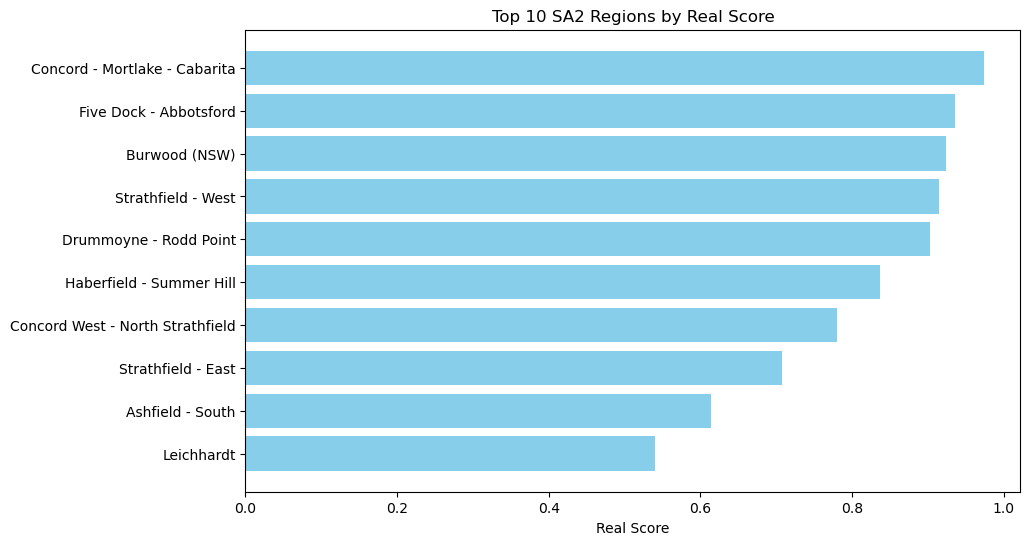

In [40]:
import matplotlib.pyplot as plt

# Bar chart: top 10 regions
top10 = final_scores.sort_values("real_score", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10["sa2_name21"], top10["real_score"], color="skyblue")
plt.xlabel("Real Score")
plt.title("Top 10 SA2 Regions by Real Score")
plt.gca().invert_yaxis()
plt.show()



### Top and Bottom Scoring Regions

The top 10 SA2 regions in the Inner West by real_score are led by **Concord – Mortlake – Cabarita**, **Five Dock – Abbotsford**, **Burwood (NSW)**, **Strathfield – West**, and **Drummoyne - Rodd Point**. These regions scored above 0.90, suggesting strong coverage in terms of public transport, schools, parks, libraries, and businesses in certain industry.

In contrast, **Ashfield - North** ranks among the lowest, with a real score close to **0.03**. 

### How Are the Scores Distributed?

Looking at the histogram of real scores, the results are kind of spread out — a bunch of regions scored really high, while a few ended up very low. This shows that the Inner West has a mix of both well-resourced and under-resourced areas, rather than being consistent across the board.

It’s also interesting how sharp the divide is — some regions are doing great in terms of access to public infrastructure, while others seem to be missing out.

### Why These Five Metrics?

To measure how well-resourced each SA2 region in the Inner West is, I selected five core metrics:

- **Public transport stops**
- **Schools (per 1,000 youth aged 5–19)**
- **Libraries**
- **Parks**
- **Businesses in Accommodation and Food Services (Industry Code H)**

I chose these specific factors because they reflect the types of public and semi-public infrastructure that really shape the daily experience of residents in Inner West.

The Inner West is known for being a vibrant, diverse, and relatively dense urban area, with strong walkability and a lot of small commercial hubs. So:

- **Public transport** is a big deal — many people rely on buses and trains instead of driving.
- **Schools** matter because this area includes a mix of young families and long-term residents.
- **Libraries and parks** were included not just for education and recreation, but because they offer free, inclusive public space — especially important in dense communities.
- For **businesses**, we specifically focused on *Accommodation and Food Services (industry H)*. These include restaurants, cafes, and hotels, which are central to Inner West’s identity. Think of places like Newtown, Marrickville, and Ashfield — food culture is part of what defines the area. Plus, these services reflect foot traffic, local vibrancy, and access to amenities, especially in areas without large shopping malls.

Altogether, I think this mix gives a balanced view of **daily livability** — not just whether a region is wealthy, but whether it feels connected, supported, and functional for everyday needs.

### Component Breakdown

We investigate how each z-score component contributes to the total score.

In [ ]:
import seaborn as sns

# Correlation matrix between z components and real score
score_corr = final_scores[["z_stops", "z_schools", "z_libraries", "z_parks", "z_businesses", "real_score"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(score_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Components and Real Score")
plt.show()

### Correlation with Income

The project's rubric asks us to determine whether real score correlates with
median income in each region.

In [ ]:
income = pd.read_csv("i_cleaned.csv")

final_scores["sa2_code21"] = final_scores["sa2_code21"].astype(str)
income["sa2_code"] = income["sa2_code"].astype(str)

income_joined = final_scores.merge(income, left_on="sa2_code21", right_on="sa2_code", how="left")

import matplotlib.pyplot as plt
# Scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(income_joined["median_income"], income_joined["real_score"], alpha=0.7)
plt.xlabel("Median Income")
plt.ylabel("Real Score")
plt.title("Real Score vs Median Income")
plt.grid(True)
plt.show()

# Correlation coefficient
income_corr = income_joined["real_score"].corr(income_joined["median_income"])
print("correlation coeffient:", income_corr)

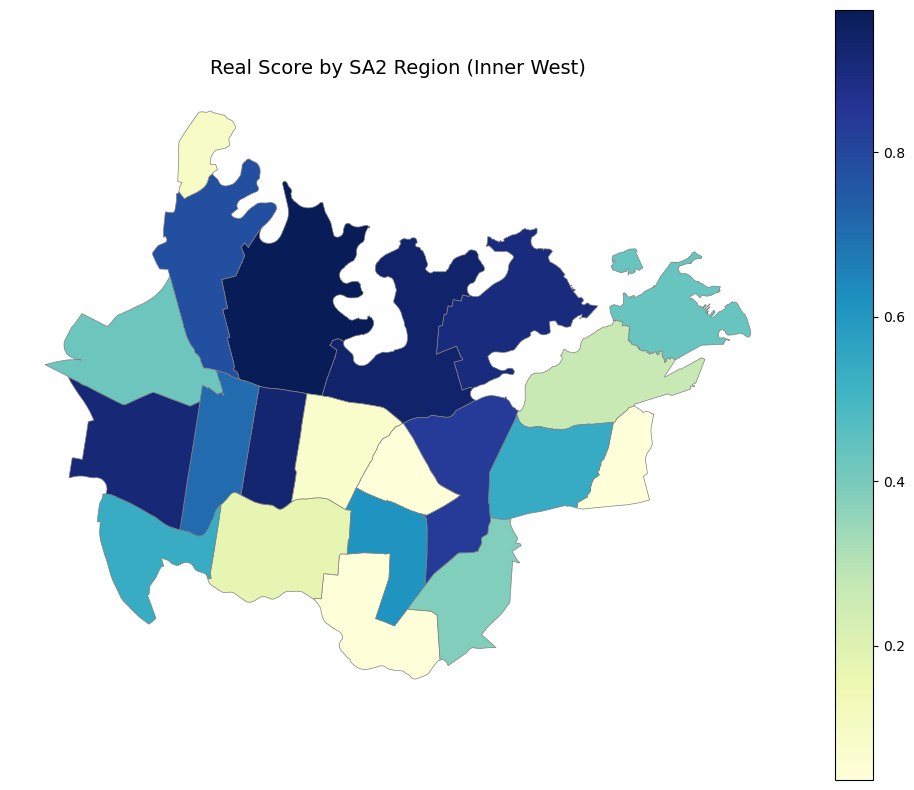

In [50]:
map_visual = innerwest_gdf.merge(final_scores, on="sa2_code21", how="left")
fig, ax = plt.subplots(figsize=(10, 8))
map_visual.plot(
    column="real_score",
    cmap="YlGnBu",
    linewidth=0.5,
    edgecolor="grey",
    legend=True,
    ax=ax
)
ax.set_title("Real Score by SA2 Region (Inner West)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

### Map Overlay: Real Score by Region

This map overlays the computed real scores on each SA2 region in the Inner West. The darker blue areas are the most well-resourced, based on our selected metrics (stops, schools, libraries, parks, and hospitality businesses). This kind of spatial visualization helps us see geographic patterns that are not obvious in tables — for example, which areas may need more infrastructure or investment.